In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Load Neural Data

In [3]:
session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160113-01.mat'
# filename = fr'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/{session}.mat'
filename = fr'/om/user/eisenaj/ChaoticConsciousness/data/propofolPuffTone/{session}.mat'
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

f = h5py.File(filename, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 101.59 seconds)


# Load Results

In [4]:
def get_result_path(results_dir, session, window):
    regex = re.compile(f"VAR_{session}_window_{window}_stride_{window}")
    matching_files = []
    for file in os.listdir(results_dir):
        if regex.match(file):
            matching_files.append(file)
    
    # pick the most recent result, if there are multiple
    if len(matching_files) == 1:
        file = matching_files[0]
    else:
        file = None
        date = datetime(1996, 11, 8)
        for test_file in matching_files:
            test_date = datetime.strptime('_'.join(file.split('_')[-2:]), '%b-%d-%Y_%H%M')
            if test_date > date:
                file = test_file
                date = test_date
    
    return os.path.join(results_dir, file)

In [5]:
results_dir = "/om/user/eisenaj/ChaoticConsciousness/results/propofol/VAR"
window = 0.15
result_path = get_result_path(results_dir, session, window)
run_data = load(result_path)

In [6]:
run_params = run_data['run_params']
results = run_data['results']

In [10]:
for area in results.keys():
    results[area]['start_time'] = pd.Series(np.arange(len(results[area]))*run_params['stride'])
    results[area]['start_step'] = pd.Series(np.int0(results[area].start_time/dt))

# Plot

## Individual Areas

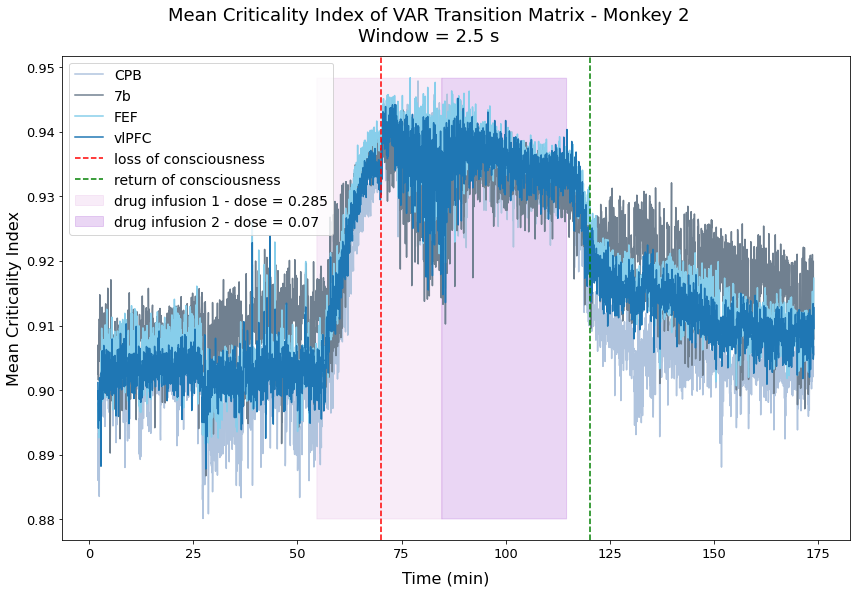

In [71]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

min_val = np.Inf
max_val = -np.Inf
for area, c in [('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('FEF', 'skyblue'), ('vlPFC', 'C0')]:
# for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]:
# for area, c in [('vlPFC', 'C0')]:
    start_times = results[area].start_time/60
    criticality_inds = results[area].eigs.apply(lambda x: x.mean())
    start_ind = 50
    start_times = start_times[start_ind:]
    criticality_inds = criticality_inds[start_ind:]
    ax.plot(start_times, criticality_inds, label=area, c=c)
    
    if criticality_inds.min() < min_val:
        min_val = criticality_inds.min()
    if criticality_inds.max() > max_val:
        max_val = criticality_inds.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], run_params['stride'])/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], run_params['stride'])/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
ax.legend(fontsize=14)        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
ax.set_ylabel('Mean Criticality Index', fontsize=16)
ax.tick_params(labelsize=13)
plt.suptitle(f"Mean Criticality Index of VAR Transition Matrix - Monkey {1 if 'Mary' in results_path else 2}\nWindow = {run_params['window']} s", fontsize=18)
plt.tight_layout()
plt.show()

## Multipopulation

NameError: name 'results_path' is not defined

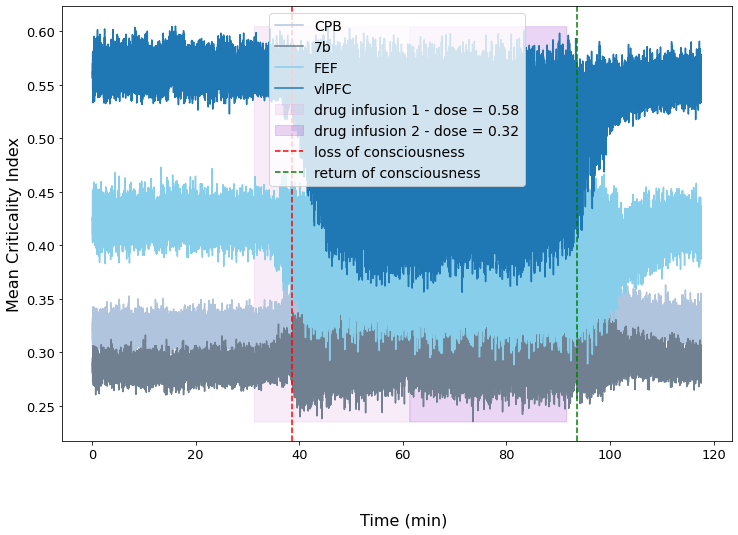

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

min_val = np.Inf
max_val = -np.Inf
# for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]:
# for area, c in [('vlPFC', 'C0')]:
# for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]:
for area, c in [('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('FEF', 'skyblue'), ('vlPFC', 'C0')]:
    start_times = results['all'].start_time/60

#     unit_indices = run_params['unit_indices'][area]
    unit_indices = np.where(electrode_info['area'] == area)[0]
    
    criticality_inds = np.zeros(len(results['all']))
    for i in range(len(criticality_inds)):
        e, _ = np.linalg.eig(results['all'].A_mat.iloc[i][unit_indices][:, unit_indices])
        criticality_inds[i] = np.abs(e).mean()
    
#     criticality_inds = results[area]['eigs'].mean(axis=1)
    start_ind = 50
    start_times = start_times[start_ind:]
    criticality_inds = criticality_inds[start_ind:]
    ax.plot(start_times, criticality_inds, label=area, c=c)
    
    if criticality_inds.min() < min_val:
        min_val = criticality_inds.min()
    if criticality_inds.max() > max_val:
        max_val = criticality_inds.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], run_params['stride'])/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], run_params['stride'])/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
ax.legend(fontsize=14)        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
ax.set_ylabel('Mean Criticality Index', fontsize=16)
ax.tick_params(labelsize=13)
plt.suptitle(f"Mean Criticality Index of VAR Transition Matrix - Monkey {1 if 'Mary' in results_path else 2}\nWindow = {run_params['window']} s", fontsize=18)
plt.tight_layout()
plt.show()

In [60]:
area = 'vlPFC'

In [61]:
bin_nums = 20
bins = [(np.concatenate(results[area].eigs.to_numpy()).max() - np.concatenate(results[area].eigs.to_numpy()).min())*i/bin_nums + np.concatenate(results[area].eigs.to_numpy()).min() for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((results[area].eigs.shape[0], bin_nums))
for t in range(results[area].eigs.shape[0]):
    criticality_prob_dist[t] = np.histogram(results[area].eigs[t], bins=bins)[0]

<ipython-input-62-e41d0aaf005f>:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


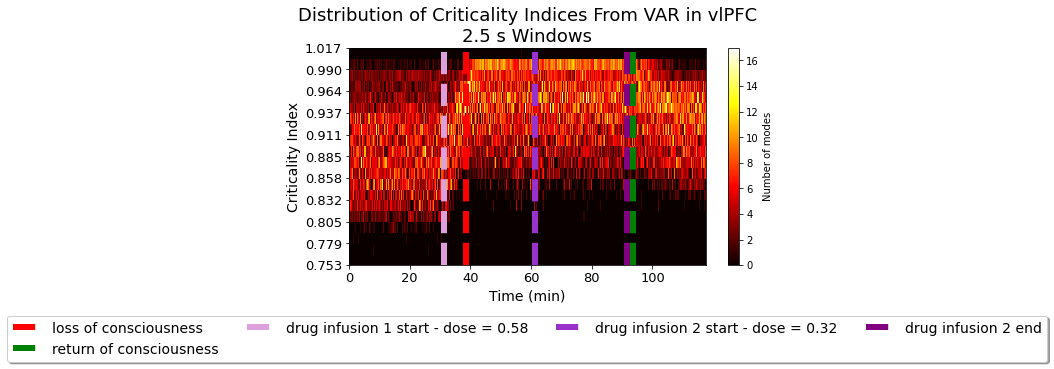

In [62]:
lw = 6
stride = run_params['stride']
plt.figure(figsize=(8, 4))
plt.pcolormesh(criticality_prob_dist.T, cmap='hot')
start_times = np.arange(results[area]['eigs'].shape[0])*stride/60
xticks = plt.xticks()
plt.xticks([int(i*60/stride) for i in np.arange(0, 120, 20)], np.arange(0, 120, 20))
plt.yticks(np.arange(0, 21, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, 21, 2)]])
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.xlabel("Time (min)", fontsize=14)
plt.ylabel("Criticality Index", fontsize=14)
plt.title(f"Distribution of Criticality Indices From VAR in {area}\n{run_params['window']} s Windows", fontsize=18)
plt.axvline(session_info['eyesClose'][-1]/stride if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', lw=lw, c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/stride if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', lw=lw, c='green', label="return of consciousness")
plt.axvline(session_info['drugStart'][0]/stride, color='plum', linestyle='--', lw=lw, label=f"drug infusion 1 start - dose = {session_info['drugDose'][0]}")
plt.axvline(session_info['drugStart'][1]/stride, color='darkorchid', linestyle='--', lw=lw, label=f"drug infusion 2 start - dose = {session_info['drugDose'][1]}")
plt.axvline(session_info['drugEnd'][1]/stride, color='purple', linestyle='--', lw=lw, label=f"drug infusion 2 end")
# ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
#     min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")
plt.legend(fontsize=14, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=True)
plt.colorbar(label="Number of modes")
plt.tight_layout()
plt.show()

<ipython-input-54-97884fc8eff6>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


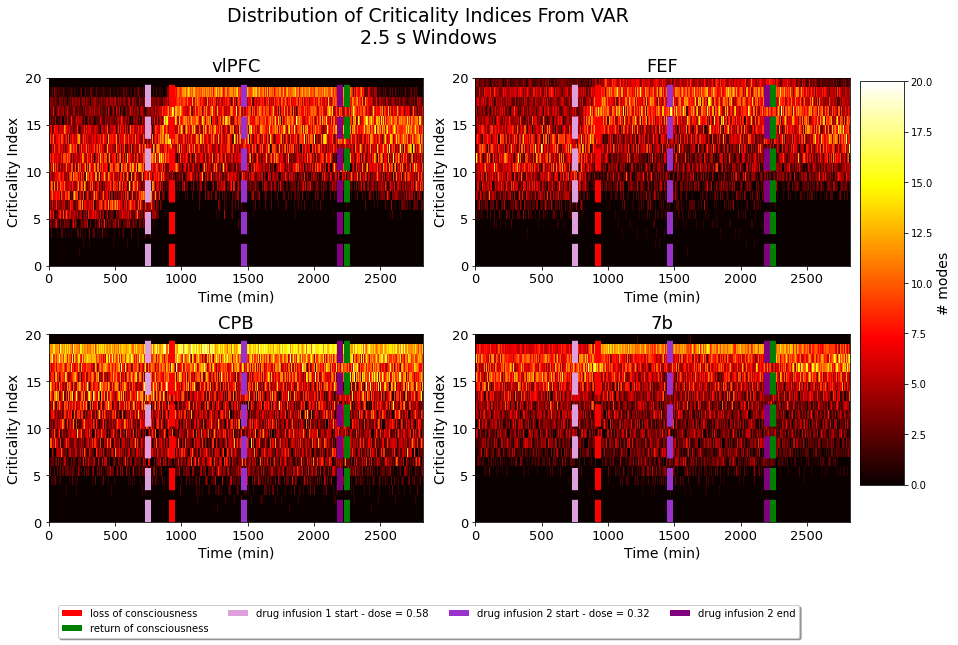

In [54]:
stride = run_params['stride']
lw = 6
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, area in enumerate(['vlPFC', 'FEF', 'CPB', '7b']):
    ax = axs[int(i/2)][i % 2]
    
    bin_nums = 20
    bins = [(np.concatenate(results[area].eigs.to_numpy()).max() - np.concatenate(results[area].eigs.to_numpy()).min())*i/bin_nums + np.concatenate(results[area].eigs.to_numpy()).min() for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((results[area].eigs.shape[0], bin_nums))
    for t in range(results[area].eigs.shape[0]):
        criticality_prob_dist[t] = np.histogram(results[area].eigs[t], bins=bins)[0]

    im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot')
    start_times = np.arange(results[area]['eigs'].shape[0])*stride/60
    xticks = plt.xticks()
#     ax.set_xticks([int(i*60/stride) for i in np.arange(0, 120, 20)], np.arange(0, 120, 20))
#     ax.set_yticks(np.arange(0, 21, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, 21, 2)]])
    ax.tick_params(labelsize=13)
    ax.set_xlabel("Time (min)", fontsize=14)
    ax.set_ylabel("Criticality Index", fontsize=14)
    ax.set_title(f"{area}", fontsize=18)
    ax.axvline(session_info['eyesClose'][-1]/stride if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', lw=lw, c='red', label="loss of consciousness")
    ax.axvline(session_info['eyesOpen'][-1]/stride if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', lw=lw, c='green', label="return of consciousness")
    ax.axvline(session_info['drugStart'][0]/stride, color='plum', linestyle='--', lw=lw, label=f"drug infusion 1 start - dose = {session_info['drugDose'][0]}")
    ax.axvline(session_info['drugStart'][1]/stride, color='darkorchid', linestyle='--', lw=lw, label=f"drug infusion 2 start - dose = {session_info['drugDose'][1]}")
    ax.axvline(session_info['drugEnd'][1]/stride, color='purple', linestyle='--', lw=lw, label=f"drug infusion 2 end")
    handles, labels = ax.get_legend_handles_labels()
    # ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
    #     min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")
#     ax.legend(fontsize=14, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True)
#     plt.colorbar(label="Number of modes")
plt.suptitle(f"Distribution of Criticality Indices From VAR\n{run_params['window']} s Windows", fontsize=19)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(label='# modes', fontsize=14)
plt.tight_layout()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True)
plt.show()

# Test

In [55]:
i = 0
area = 'all'

In [86]:
unit_indices = run_params['unit_indices'][area]
T_pred = 25
row = results[area].iloc[i]
x0 = lfp[row.start_step + int(run_params['window']/dt) - 1, unit_indices]
predictions = np.zeros((T_pred, len(unit_indices)))
for t in range(T_pred):
    if t == 0:
        predictions[t] = np.concatenate([[1], x0]) @ row.A_mat_with_bias
    else:
        predictions[t] = np.concatenate([[1], predictions[t-1]]) @ row.A_mat_with_bias

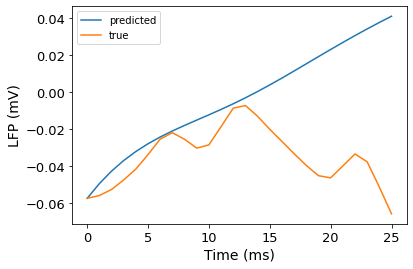

In [111]:
unit_num = 2
plt.plot(np.concatenate([[x0], predictions])[:, unit_num], label='predicted')
plt.plot(lfp[row.start_step + int(run_params['window']/dt) - 1:row.start_step + int(run_params['window']/dt) + T_pred, unit_indices[unit_num]], label='true')
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('LFP (mV)', fontsize=14)
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.legend()
plt.show()